In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [146]:
# Parameters
v = 50  # free-flow speed (km/h)

d_HV_HV     = 7.0   # m
d_plt_HV    = 7.0   # m
d_HV_plt    = 7.0   # m
d_plt_plt   = 5.0   # m
d_CAV_CAV   = 5.0   # m

tau_HV_HV   = 1.60  # s
tau_plt_HV  = 1.50  # s
tau_HV_plt  = 1.50  # s
tau_plt_plt = 1.10  # s
tau_CAV_CAV = 0.60  # s

In [147]:
# Calculation functions
def compute_P0(P, L):
    return (1 - P**L) / (1 - P**L + P)

def compute_bar_d_tau(P, L, gamma):
    P0 = compute_P0(P, L)
    # 1) bar_d
    term1 = (1 - P) * (gamma*(1-P0) + P0) * d_HV_HV
    term2 = (1 - P) * (1-P0)*(1-gamma) * (d_plt_HV + d_HV_plt)
    term3 = (1 - P)/P0 * (1-P0)*(gamma*P0 + 1-P0) * d_plt_plt
    term4 = (1 - (1 - P)/P0) * d_CAV_CAV
    bar_d = term1 + term2 + term3 + term4
    # 2) bar_tau
    term1 = (1 - P) * (gamma*(1-P0) + P0) * tau_HV_HV
    term2 = (1 - P) * (1-P0)*(1-gamma) * (tau_plt_HV + tau_HV_plt)
    term3 = (1 - P)/P0 * (1-P0)*(gamma*P0 + 1-P0) * tau_plt_plt
    term4 = (1 - (1 - P)/P0) * tau_CAV_CAV
    bar_tau = term1 + term2 + term3 + term4

    return bar_d, bar_tau

def mixed_QV(K, P, L, gamma, v_f):
    bar_d, bar_tau = compute_bar_d_tau(P, L, gamma)
    d_km = bar_d / 1000.0 # m -> km
    tau_h = bar_tau / 3600.0 # sec -> hr

    Kj = 1.0 / d_km
    Kc = 1.0 / (d_km + v_f * tau_h)

    K = np.asarray(K)
    Q = np.where(
        K < Kc,
        v_f * K,
        (1.0 / tau_h) - (d_km / tau_h) * K
    )

    V = Q / K
    V[K < Kc] = v_f

    return Q, V, Kj, Kc

/tmp/ipython-input-147-1081596851.py:37: RuntimeWarning: invalid value encountered in divide
  V = Q / K


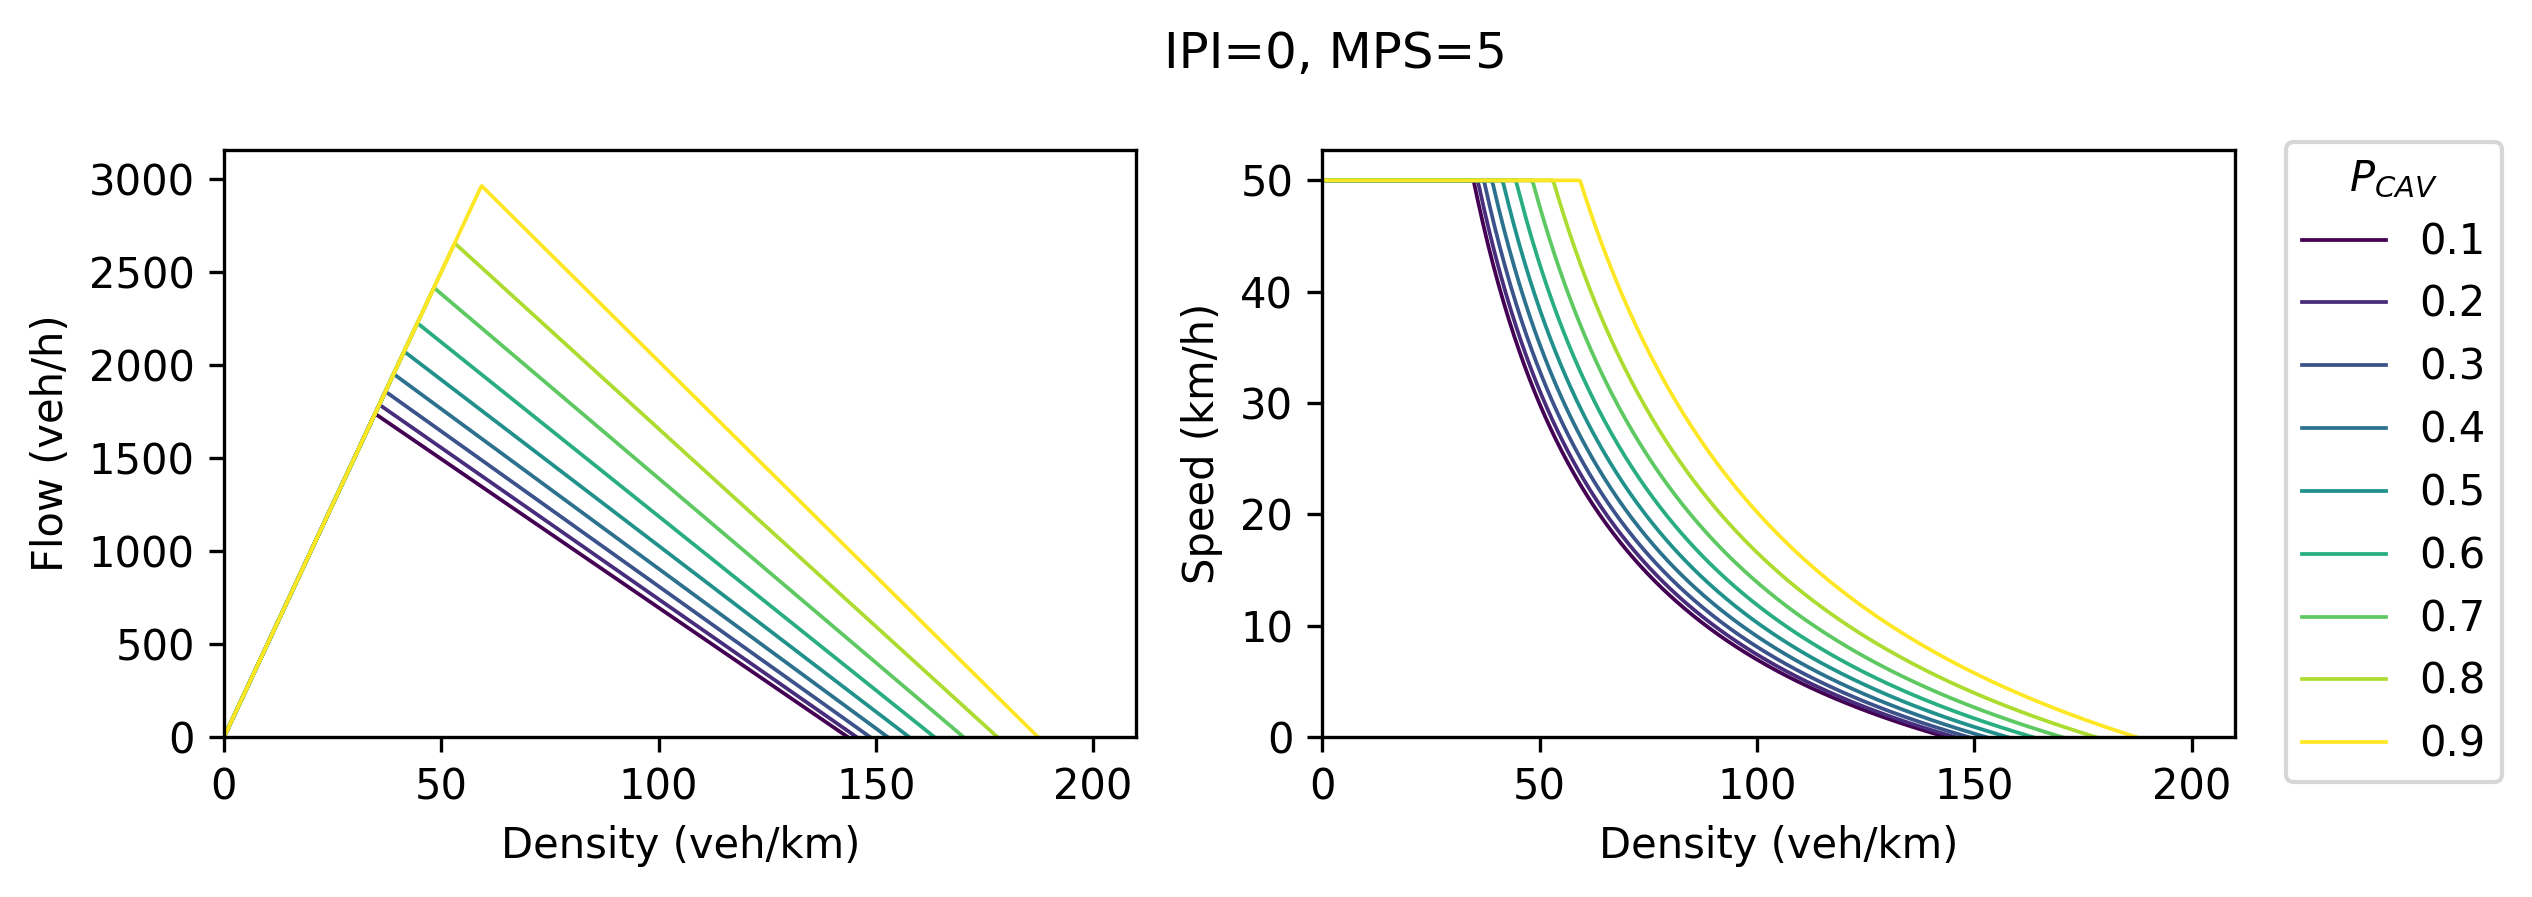

In [148]:
penetrations = np.linspace(0.1, 0.9, 9)
colors       = plt.cm.viridis(np.linspace(0,1,len(penetrations)))
gamma        = 0
L            = 5

k_values = np.linspace(0, 200, 500)

records = []
for P in penetrations:
    _, _, Kj, Kc = mixed_QV(k_values, P, L, gamma, v)
    C = v * Kc
    records.append({
        "P_CAV":       P,
        "Kj (veh/km)": Kj,
        "Kc (veh/km)": Kc,
        "C (veh/h)":   C
    })
df_PCAV = pd.DataFrame(records)

fig, (ax_flow, ax_speed) = plt.subplots(nrows=1, ncols=2, figsize=(9, 3), dpi=300)

for P, c in zip(penetrations, colors):
    Qv, Vv, _, _ = mixed_QV(k_values, P, L, gamma, v)
    ax_flow .plot(k_values, Qv, color=c, linewidth=0.9)
    ax_speed.plot(k_values, Vv, color=c, linewidth=0.9)

for ax in (ax_flow, ax_speed):
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
ax_flow .set_xlabel("Density (veh/km)")
ax_speed.set_xlabel("Density (veh/km)")
ax_flow .set_ylabel("Flow (veh/h)")
ax_speed.set_ylabel("Speed (km/h)")

fig.suptitle(f"IPI={gamma}, MPS={L}")
# legend
fig.legend(
    [f"{p:.1f}" for p in penetrations],
    title="$P_{CAV}$",
    loc='center right',
    bbox_to_anchor=(0.94, 0.5)
)

plt.tight_layout(rect=[0,0,0.85,1])
plt.show()

In [149]:
df_PCAV

,P_CAV,Kj (veh/km),Kc (veh/km),C (veh/h)
0,0.1,143.603102,34.767021,1738.351072
1,0.2,145.629559,35.741918,1787.095917
2,0.3,148.728034,37.153367,1857.668374
3,0.4,152.779439,39.038850,1951.942501
4,0.5,157.718121,41.460164,2073.008210
5,0.6,163.523612,44.507082,2225.354098
6,0.7,170.236991,48.313168,2415.658392
7,0.8,178.020073,53.095727,2654.786327
8,0.9,187.355175,59.268886,2963.444291


/tmp/ipython-input-147-1081596851.py:37: RuntimeWarning: invalid value encountered in divide
  V = Q / K


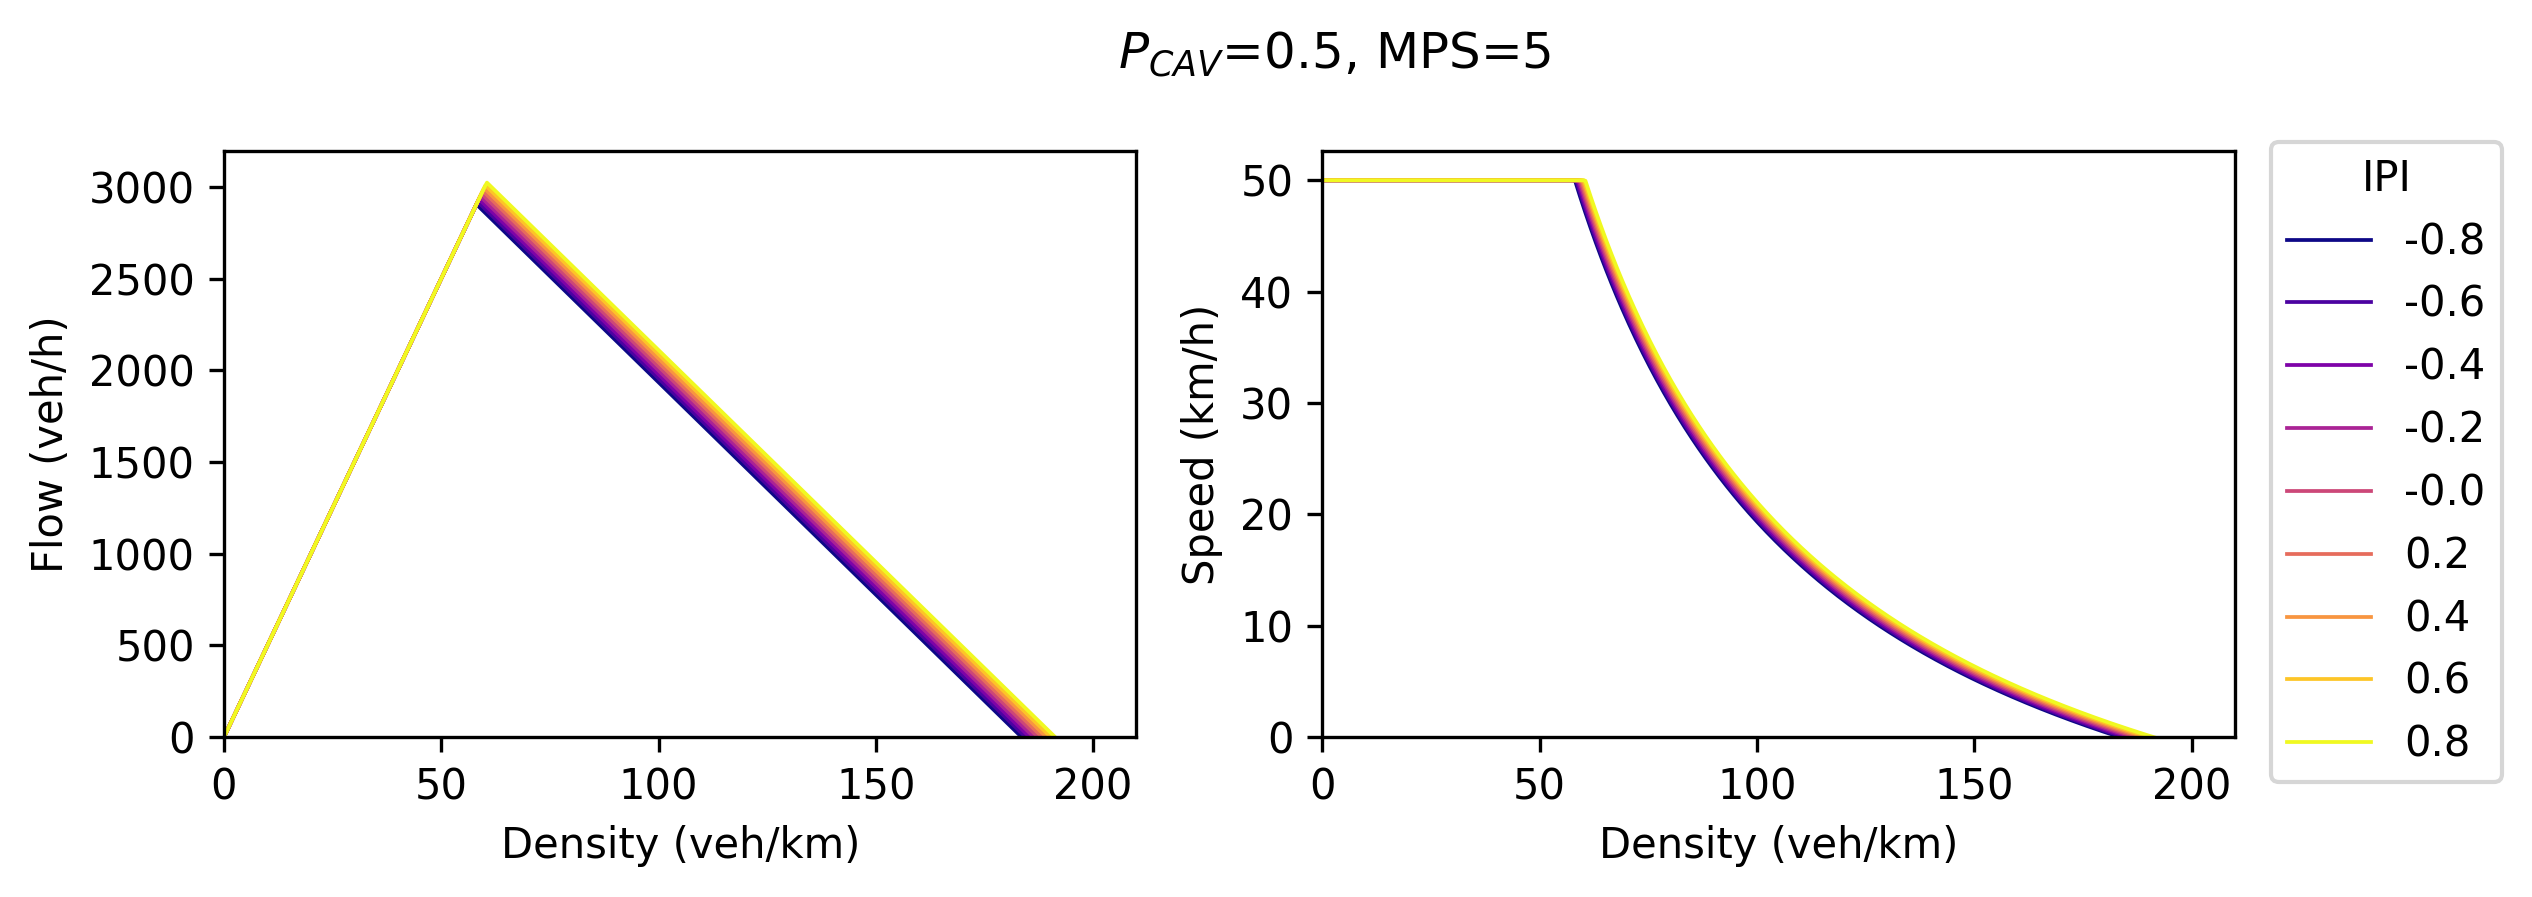

In [153]:
P_CAV = 0.5
L = 5
k_values = np.linspace(0, 200, 500)
IPI_list = np.arange(-0.8, 0.81, 0.2)
colors   = plt.cm.plasma(np.linspace(0,1,len(penetrations)))

records = []
for gamma in IPI_list:
    _, _, Kj, Kc = mixed_QV(k_values, P, L, gamma, v)
    C = v * Kc
    records.append({
        "IPI":       gamma,
        "Kj (veh/km)": Kj,
        "Kc (veh/km)": Kc,
        "C (veh/h)":   C
    })
df_IPI = pd.DataFrame(records)

fig, (ax_flow, ax_speed) = plt.subplots(nrows=1, ncols=2, figsize=(9, 3), dpi=300)

for gamma, c in zip(IPI_list, colors):
    Qv, Vv, _, _ = mixed_QV(k_values, P, L, gamma, v)
    ax_flow .plot(k_values, Qv, color=c, linewidth=0.9)
    ax_speed.plot(k_values, Vv, color=c, linewidth=0.9)

# 坐标轴
for ax in (ax_flow, ax_speed):
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
ax_flow .set_xlabel("Density (veh/km)")
ax_speed.set_xlabel("Density (veh/km)")
ax_flow .set_ylabel("Flow (veh/h)")
ax_speed.set_ylabel("Speed (km/h)")

fig.suptitle(f"$P_{{CAV}}$={P_CAV}, MPS={L}")
# legend
fig.legend(
    [f"{ipi:.1f}" for ipi in IPI_list],
    title="IPI",
    loc='center right',
    bbox_to_anchor=(0.94, 0.5)
)

plt.tight_layout(rect=[0,0,0.85,1])
plt.show()

In [154]:
df_IPI

,IPI,Kj (veh/km),Kc (veh/km),C (veh/h)
0,-8.000000e-01,183.573114,58.101305,2905.065270
1,-6.000000e-01,184.504242,58.388866,2919.443324
2,-4.000000e-01,185.444863,58.679288,2933.964408
3,-2.000000e-01,186.395124,58.972613,2948.630668
4,-2.220446e-16,187.355175,59.268886,2963.444291
5,2.000000e-01,188.325166,59.568150,2978.407511
6,4.000000e-01,189.305253,59.870452,2993.522603
7,6.000000e-01,190.295595,60.175838,3008.791894
8,8.000000e-01,191.296353,60.484355,3024.217753


/tmp/ipython-input-147-1081596851.py:37: RuntimeWarning: invalid value encountered in divide
  V = Q / K


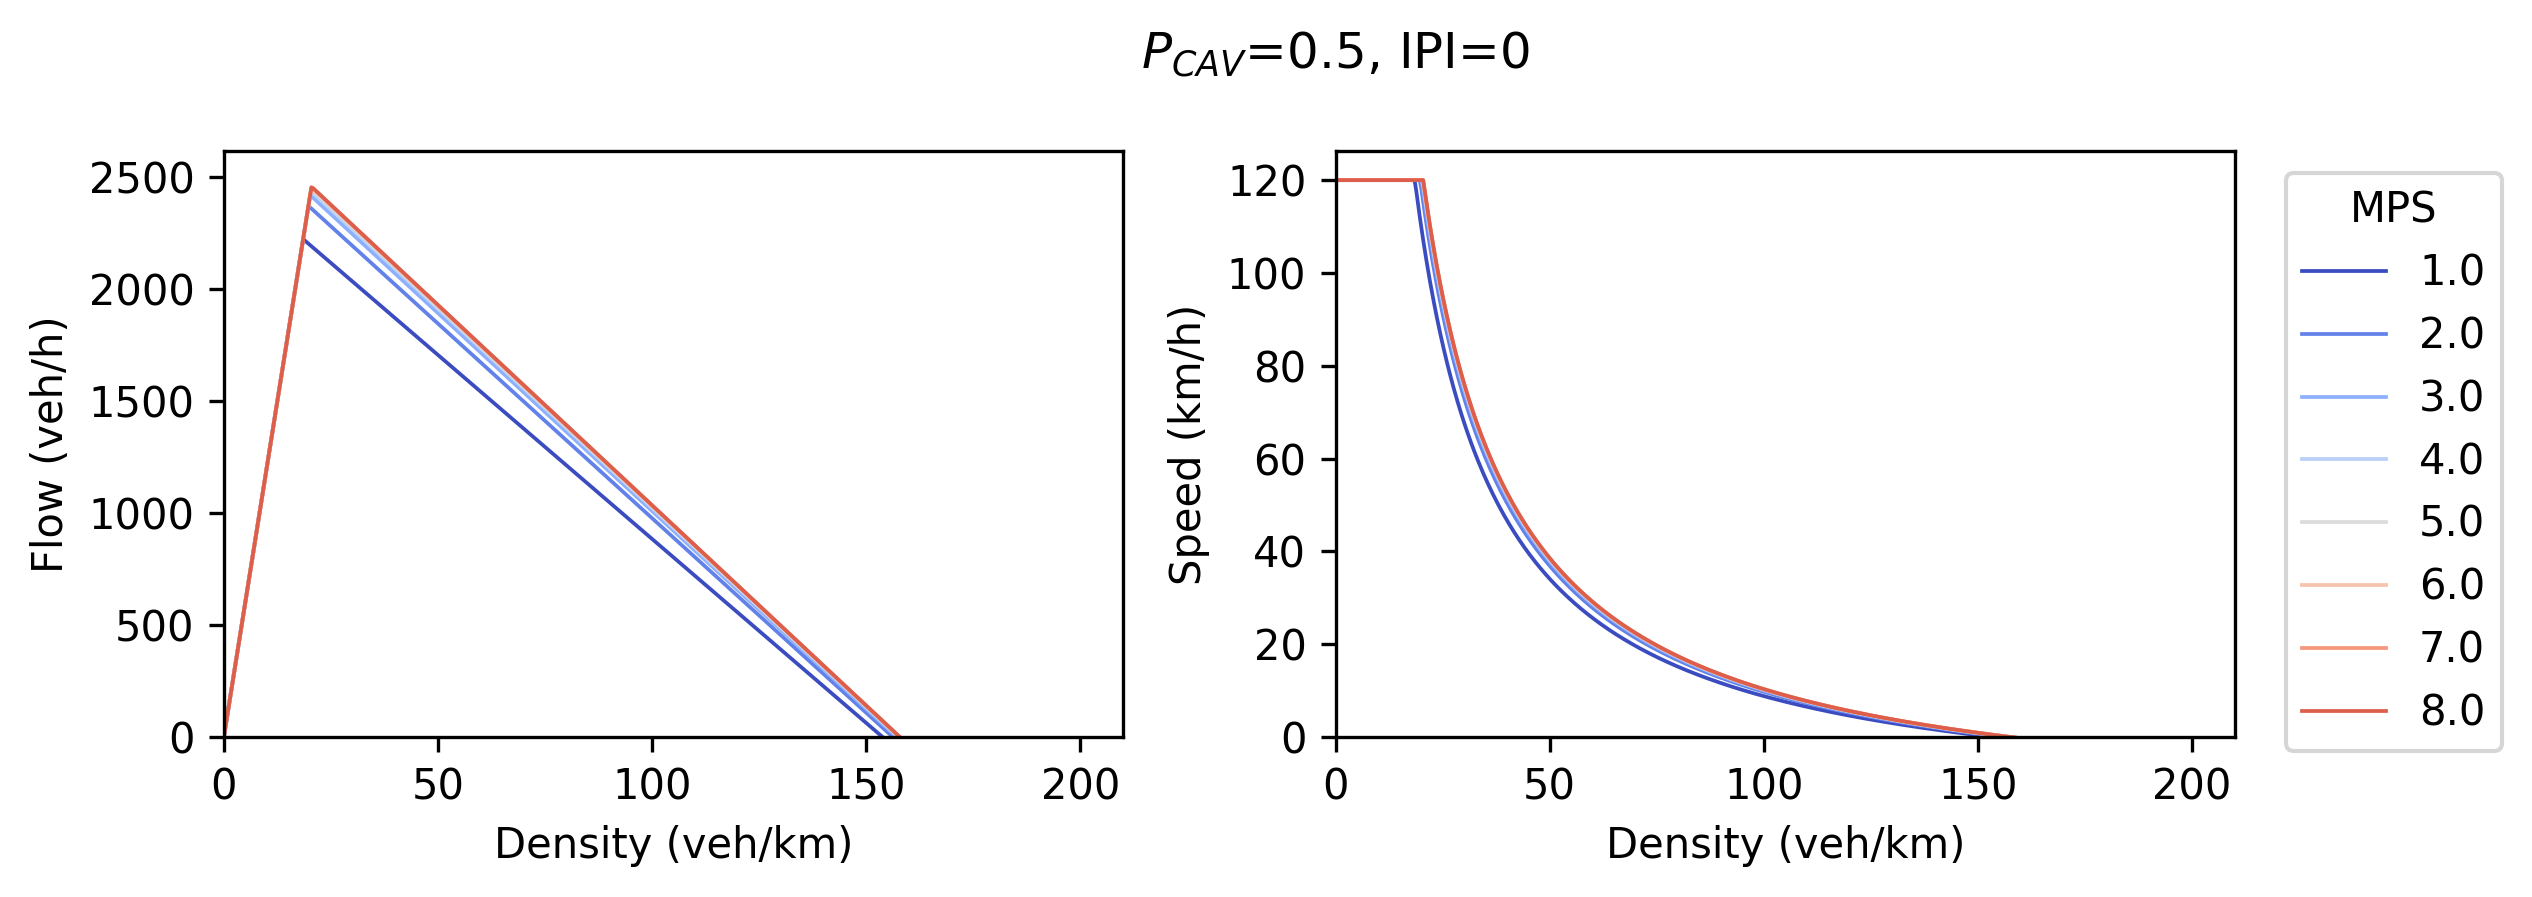

In [161]:
P_CAV = 0.5
gamma = 0
k_values = np.linspace(0, 200, 500)
L_list = [1,2,3,4,5,6,7,8]
colors   = plt.cm.coolwarm(np.linspace(0,1,len(penetrations)))

records = []
for L in L_list:
    _, _, Kj, Kc = mixed_QV(k_values, P, L, gamma, v)
    C = v * Kc
    records.append({
        "MPS":       L,
        "Kj (veh/km)": Kj,
        "Kc (veh/km)": Kc,
        "C (veh/h)":   C
    })
df_L = pd.DataFrame(records)

fig, (ax_flow, ax_speed) = plt.subplots(nrows=1, ncols=2, figsize=(9, 3), dpi=300)

for L, c in zip(L_list, colors):
    Qv, Vv, _, _ = mixed_QV(k_values, P, L, gamma, v)
    ax_flow .plot(k_values, Qv, color=c, linewidth=0.9)
    ax_speed.plot(k_values, Vv, color=c, linewidth=0.9)

# 坐标轴
for ax in (ax_flow, ax_speed):
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
ax_flow .set_xlabel("Density (veh/km)")
ax_speed.set_xlabel("Density (veh/km)")
ax_flow .set_ylabel("Flow (veh/h)")
ax_speed.set_ylabel("Speed (km/h)")

fig.suptitle(f"$P_{{CAV}}$={P_CAV}, IPI={gamma}")
# legend
fig.legend(
    [f"{l:.1f}" for l in L_list],
    title="MPS",
    loc='center right',
    bbox_to_anchor=(0.94, 0.5)
)

plt.tight_layout(rect=[0,0,0.85,1])
plt.show()

In [162]:
df_L

,MPS,Kj (veh/km),Kc (veh/km),C (veh/h)
0,1,153.846154,18.518519,2222.222222
1,2,156.250000,19.754170,2370.500439
2,3,157.142857,20.157068,2418.848168
3,4,157.534247,20.326002,2439.120189
4,5,157.718121,20.403876,2448.465158
5,6,157.807309,20.441318,2452.958213
6,7,157.851240,20.459683,2455.161943
7,8,157.873042,20.468778,2456.253353
